In [ ]:
# Cell 1: Install necessary libraries
# This cell installs all required Python packages for the notebook.
# It includes libraries for machine learning (tensorflow, scikit-learn, tensorflow-addons),
# numerical and scientific computing (scipy, numpy), plotting (matplotlib, seaborn),
# and Q# integration for quantum random number generation (qsharp, qsharp-widgets).
# ipykernel is also included for Jupyter notebook compatibility.
!pip install tensorflow scipy numpy matplotlib scikit-learn seaborn tensorflow-addons qsharp qsharp-widgets ipykernel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
# Cell 2: Imports
# This cell imports all the necessary Python modules and libraries that will be used throughout the notebook.
import numpy as np  # For numerical operations, especially array manipulation.
import tensorflow as tf  # For building and training neural networks.
from tensorflow.keras.utils import to_categorical # For converting class vectors to binary class matrices.
from tensorflow.keras.models import Sequential # For creating a linear stack of layers for the NN.
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization # Core layers for the NN.
from tensorflow.keras.optimizers import Adam # Optimizer for training the NN.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Callbacks to improve training.
from tensorflow.keras import regularizers # For applying penalties on layer parameters to prevent overfitting.
from sklearn.model_selection import train_test_split # For splitting data into training and testing sets.
from sklearn.preprocessing import StandardScaler # For feature scaling.
from sklearn.metrics import confusion_matrix, classification_report # For evaluating model performance.
import matplotlib.pyplot as plt # For creating static, interactive, and animated visualizations.
import seaborn as sns # For making statistical graphics, built on top of matplotlib.
import secrets # For generating cryptographically strong random numbers (used for healthy TRNG).
import random # For generating pseudo-random numbers for simulations.
from scipy.stats import chisquare, entropy, kstest, skew, kurtosis, norm # For various statistical tests.
from scipy.fftpack import fft # For Fast Fourier Transform.
from scipy.signal import periodogram, sawtooth # For signal processing, including PSD and generating sawtooth waves.
import math # For basic mathematical functions.
import os # For interacting with the operating system (e.g., file paths).
import time # For time-related tasks, like measuring execution time.
import re # For regular expression operations (used for validating input strings).
from collections import Counter # For counting hashable objects (e.g., repetitions in data).
from google.colab import drive # For mounting Google Drive to access files in Colab.

# Attempt to import qsharp; print a message if it's not found, as QRNG tests will fail.
try:
    import qsharp
except ImportError:
    print("Qsharp not installed or imported, QRNG testing cell might fail.")
    qsharp = None # Set to None so later checks can handle its absence.

In [ ]:
# Cell 3: RNG Generation Functions
# This cell defines various functions to generate sequences of bytes that simulate
# different types of Random Number Generators (RNGs), both healthy and flawed.

def generate_healthy_trng(length):
    """Uses OS CSPRNG (Cryptographically Secure Pseudo-Random Number Generator)
    as a stand-in for high-quality TRNG (True Random Number Generator)."""
    return secrets.token_bytes(length)

def generate_biased_trng(length, bias=0.6):
    """Simulates a TRNG with bit bias.
    Each bit has a probability 'bias' of being 1, and (1-bias) of being 0."""
    byte_list = []
    for _ in range(length): # For each byte to generate
        byte_val = 0
        for _ in range(8): # For each of the 8 bits in a byte
            bit = 1 if random.random() < bias else 0
            byte_val = (byte_val << 1) | bit # Shift current byte value left and add the new bit
        byte_list.append(byte_val)
    return bytes(byte_list)

def generate_stuck_trng(length, stuck_value=0x00, stuck_prob=0.1, run_length=5):
    """Simulates a TRNG that intermittently gets 'stuck' at a specific byte value
    for a certain number of consecutive bytes (run_length)."""
    healthy_data = bytearray(generate_healthy_trng(length)) # Start with healthy data
    i = 0
    while i < length:
        if random.random() < stuck_prob: # Check if the generator gets stuck
            current_run = min(run_length, length - i) # Determine how long it stays stuck
            for j in range(current_run):
                healthy_data[i+j] = stuck_value # Set bytes to the stuck value
            i += current_run
        else:
            i += 1
    return bytes(healthy_data)

def generate_reduced_entropy_trng(length, min_val=64, max_val=191):
    """Simulates reduced entropy by clamping the output byte values to a specific range."""
    healthy_data = generate_healthy_trng(length)
    # Scale healthy byte values (0-255) to the new [min_val, max_val] range
    scaled_data = [int(min_val + (byte / 255.0) * (max_val - min_val)) for byte in healthy_data]
    return bytes(scaled_data)

def generate_periodic_trng(length, period=32, amplitude=10):
    """Simulates injecting a weak periodic signal (sawtooth wave) into healthy TRNG data."""
    healthy_data = np.frombuffer(generate_healthy_trng(length), dtype=np.uint8).astype(np.int16)
    t = np.arange(length) # Time vector
    # Generate a sawtooth wave signal
    periodic_signal = amplitude * sawtooth(2 * np.pi * t / period, width=0.5) # width=0.5 makes it a triangle wave
    noisy_data = healthy_data + periodic_signal.astype(np.int16) # Add the signal to healthy data
    noisy_data = np.clip(noisy_data, 0, 255) # Ensure data remains within the valid byte range (0-255)
    return noisy_data.astype(np.uint8).tobytes() # Convert back to bytes

def generate_correlated_trng(length, alpha=0.5):
    """Simulates autocorrelation by blending consecutive bytes.
    Each new byte is a weighted average of a fresh healthy random byte and the previously generated correlated byte."""
    healthy_data = np.frombuffer(generate_healthy_trng(length), dtype=np.uint8)
    correlated_data = np.zeros_like(healthy_data, dtype=np.uint8) # Ensure correct dtype
    correlated_data[0] = healthy_data[0]
    for i in range(1, length):
        # Weighted average, ensuring the result is an integer and clipped to byte range
        new_val = int(alpha * healthy_data[i] + (1 - alpha) * correlated_data[i-1])
        correlated_data[i] = max(0, min(255, new_val)) # Clip to 0-255
    return correlated_data.tobytes()

class SimpleLCG:
    """A simple Linear Congruential Generator (LCG) class."""
    def __init__(self, seed=None, a=1664525, c=1013904223, m=2**32):
        self.a = a # Multiplier
        self.c = c # Increment
        self.m = m # Modulus
        if seed is None:
            self.state = int.from_bytes(os.urandom(4), 'big') # Use a random seed if none provided
        else:
            self.state = seed
        self.state %= self.m # Ensure seed is within modulus

    def next_int(self):
        """Generates the next pseudo-random integer."""
        self.state = (self.a * self.state + self.c) % self.m
        return self.state

    def next_byte(self):
        """Generates the next pseudo-random byte (least significant byte of the integer)."""
        return self.next_int() & 0xFF # Mask to get the last 8 bits

def generate_lcg_bytes(length, seed=None):
    """Generates a sequence of bytes using a simple Linear Congruential Generator.
    LCGs are known to have statistical flaws and are not suitable for cryptographic purposes."""
    lcg = SimpleLCG(seed)
    byte_list = [lcg.next_byte() for _ in range(length)]
    return bytes(byte_list)

print("RNG generation functions defined.")

RNG generation functions defined.


In [ ]:
# Cell 4: Feature Extraction Function

def runs_test(sequence):
    n = len(sequence); median = np.median(sequence);
    if n < 2: return 0.5
    if isinstance(sequence, bytes): seq_int = np.frombuffer(sequence, dtype=np.uint8)
    elif not isinstance(sequence, np.ndarray) or sequence.dtype != np.uint8 :
         seq_int = np.array(sequence, dtype=np.uint8)
    else: seq_int = sequence

    if len(seq_int) < 2: return 0.5

    median = np.median(seq_int); signs = np.sign(seq_int - median)
    for i in range(1, n):
      if signs[i] == 0 and i > 0: signs[i] = signs[i-1]
      elif signs[i] == 0 and i==0: signs[i]=1

    if np.all(signs == signs[0]) or np.all(signs==0): return 0.0

    runs = 1
    for i in range(1, n):
      if signs[i] != signs[i-1]: runs += 1

    n1 = np.sum(signs > 0); n2 = np.sum(signs < 0)

    if n1 == 0 or n2 == 0: return 0.0
    if (n1 + n2) <= 1 : return 0.5

    runs_exp = ((2.0 * n1 * n2) / (n1 + n2)) + 1
    std_dev_sq = (2.0 * n1 * n2 * (2.0 * n1 * n2 - n1 - n2)) / (((n1 + n2)**2) * (n1 + n2 - 1.0))

    if std_dev_sq <= 0 or (n1 + n2 -1) == 0:
         return 0.0 if abs(runs - runs_exp) > 1e-6 else 0.5

    std_dev_runs = np.sqrt(std_dev_sq);
    if std_dev_runs < 1e-9:
         return 0.0 if abs(runs - runs_exp) > 1e-6 else 0.5

    z = (runs - runs_exp) / std_dev_runs
    p_value = 2.0 * (1.0 - norm.cdf(abs(z)))
    return p_value if not math.isnan(p_value) else 0.5

def extract_enhanced_features(sequence):
    seq_int = np.frombuffer(sequence, dtype=np.uint8)
    n = len(seq_int)
    num_fft_coeffs = 64
    num_psd_coeffs = 32
    num_bins = 16
    num_lags = 8
    num_basic_stats = 11 # mean, std, ent, chi_p, ks_p, skew, kurt, runs_p, high_bytes, transitions, monotonic
    expected_len = num_basic_stats + num_lags + num_fft_coeffs + num_psd_coeffs + num_bins

    if n == 0: return np.zeros(expected_len)

    mean_val = np.mean(seq_int); std_dev = np.std(seq_int)
    if n > 3 and std_dev > 1e-6:
        skew_val = skew(seq_int); kurtosis_val = kurtosis(seq_int)
    else: skew_val = 0.0; kurtosis_val = -3.0

    counts = np.bincount(seq_int, minlength=256);
    if n > 0: freq = counts / n; ent_val = entropy(freq, base=2)
    else: freq = np.zeros(256); ent_val = 0.0

    chi_stat, chi_p = chisquare(counts) if np.sum(counts) > 0 else (0.0, 1.0)

    ks_stat, ks_p = kstest(seq_int / 255.0, 'uniform') if n > 0 else (0.0, 1.0)

    autocorrs = []; lags_to_use = [1, 2, 3, 5, 8, 13, 21, 34][:num_lags]
    for lag in lags_to_use:
        if lag < n:
             valid_data = seq_int[:-lag]
             valid_data_lagged = seq_int[lag:]
             if np.std(valid_data) > 1e-6 and np.std(valid_data_lagged) > 1e-6:
                  corr = np.corrcoef(valid_data, valid_data_lagged)[0, 1];
                  autocorrs.append(corr if not math.isnan(corr) else 0.0)
             else:
                  autocorrs.append(0.0)
        else: autocorrs.append(0.0)

    runs_pval = runs_test(seq_int) if n > 1 else 0.5

    fft_features = np.zeros(num_fft_coeffs)
    if n > 1:
         fft_coeffs = np.abs(fft(seq_int - mean_val))
         num_fft_points = min(n // 2, num_fft_coeffs + 1)
         if num_fft_points > 1:
              valid_fft_coeffs = fft_coeffs[1:num_fft_points]
              log_fft = np.log(valid_fft_coeffs + 1e-10)
              if len(log_fft) < num_fft_coeffs:
                   fft_features = np.pad(log_fft, (0, num_fft_coeffs - len(log_fft)))
              else:
                    fft_features = log_fft[:num_fft_coeffs]

    psd_features = np.zeros(num_psd_coeffs)
    if n > 1:
        freqs, psd = periodogram(seq_int)
        num_psd_points = min(len(psd), num_psd_coeffs + 1)
        if num_psd_points > 1:
             valid_psd = psd[1:num_psd_points]
             log_psd = np.log(valid_psd + 1e-10)
             if len(log_psd) < num_psd_coeffs:
                  psd_features = np.pad(log_psd, (0, num_psd_coeffs - len(log_psd)))
             else:
                  psd_features = log_psd[:num_psd_coeffs]

    high_bytes = np.sum(seq_int >= 128) / n if n > 0 else 0.0
    byte_transitions = np.mean(np.abs(np.diff(seq_int.astype(float)))) if n > 1 else 0.0
    monotonic_runs = np.sum(np.diff(np.sign(np.diff(seq_int.astype(float)))) != 0) + 1 if n > 2 else (1.0 if n > 1 else 0.0)

    bins = np.histogram(seq_int, bins=num_bins, range=(0, 255))[0] / n if n > 0 else np.zeros(num_bins)

    feature_vector = np.array([
        mean_val / 255.0, std_dev / 128.0,
        ent_val / 8.0,
        chi_p, ks_p,
        skew_val, kurtosis_val,
        runs_pval,
        high_bytes,
        byte_transitions / 255.0,
        monotonic_runs / n if n > 0 else 0.0
    ] + autocorrs + list(fft_features) + list(psd_features) + list(bins))

    feature_vector = np.nan_to_num(feature_vector, nan=0.0, posinf=1e6, neginf=-1e6)
    if len(feature_vector) != expected_len:
        print(f"Warning: Feature vector length mismatch! Expected {expected_len}, Got {len(feature_vector)}. Padding/Truncating.")
        if len(feature_vector) < expected_len:
             feature_vector = np.pad(feature_vector, (0, expected_len - len(feature_vector)))
        else:
             feature_vector = feature_vector[:expected_len]

    return feature_vector

test_seq_len = 100
test_seq = secrets.token_bytes(test_seq_len)
test_features = extract_enhanced_features(test_seq)
EXPECTED_FEATURE_LENGTH = len(test_features)
print(f"Expected feature length: {EXPECTED_FEATURE_LENGTH}")

Expected feature length: 131


In [ ]:
# Cell 5: Data Generation Parameters and Setup for Multi-Class Model
# This cell defines parameters for generating a dataset for a multi-class classifier.
# The goal is to distinguish between "Healthy" TRNG sequences and various specific flaw types,
# including sequences from a Linear Congruential Generator (LCG) as another flawed class.

SEQ_LENGTH = 1024  # Length of each RNG sequence in bytes.
NUM_SAMPLES_HEALTHY = 8000 # Number of healthy samples.
NUM_SAMPLES_PER_FLAW = 1500 # Number of samples for each simulated TRNG flaw type.
NUM_SAMPLES_LCG = 1500 # Number of samples for the LCG flawed class.
DATA_FILE_X = 'rng_features_X_multiclass.npy' # Filename for saving feature data.
DATA_FILE_Y = 'rng_labels_y_multiclass.npy' # Filename for saving label data.

# Define the classes for multi-class RNG flaw detection.
RNG_CLASSES = {
    0: "Healthy",
    1: "Biased",
    2: "Stuck_00",
    3: "Stuck_FF",
    4: "ReducedEntropy",
    5: "Periodic",
    6: "Correlated",
    7: "LCG_Flawed" # Added LCG as a distinct flawed class
}
NUM_CLASSES = len(RNG_CLASSES) # Total number of classes.

# Dictionary of RNG generation functions, mapped by class index.
# Parameters for flaw generation are randomized to create more diverse flawed data.
rng_generators = {
    0: lambda: generate_healthy_trng(SEQ_LENGTH),
    1: lambda: generate_biased_trng(SEQ_LENGTH, bias=random.uniform(0.55, 0.75)), # Varied bias
    2: lambda: generate_stuck_trng(SEQ_LENGTH, stuck_value=0x00, stuck_prob=random.uniform(0.03, 0.15), run_length=random.randint(2, 10)), # Varied params
    3: lambda: generate_stuck_trng(SEQ_LENGTH, stuck_value=0xFF, stuck_prob=random.uniform(0.03, 0.15), run_length=random.randint(2, 10)), # Varied params
    4: lambda: generate_reduced_entropy_trng(SEQ_LENGTH, min_val=random.randint(20, 90), max_val=random.randint(160, 230)), # Wider range
    5: lambda: generate_periodic_trng(SEQ_LENGTH, period=random.randint(10, 70), amplitude=random.randint(4, 25)), # Wider range
    6: lambda: generate_correlated_trng(SEQ_LENGTH, alpha=random.uniform(0.2, 0.8)), # Wider range
    7: lambda: generate_lcg_bytes(SEQ_LENGTH, seed=random.randint(0, 2**32 - 1)) # LCG with random seed
}

# Define the number of samples to generate for each class.
samples_per_class = {
    0: NUM_SAMPLES_HEALTHY,
    1: NUM_SAMPLES_PER_FLAW,
    2: NUM_SAMPLES_PER_FLAW,
    3: NUM_SAMPLES_PER_FLAW,
    4: NUM_SAMPLES_PER_FLAW,
    5: NUM_SAMPLES_PER_FLAW,
    6: NUM_SAMPLES_PER_FLAW,
    7: NUM_SAMPLES_LCG
}

# Remove old data files if they exist to ensure fresh generation.
if os.path.exists(DATA_FILE_X):
    os.remove(DATA_FILE_X)
    print(f"Removed old file: {DATA_FILE_X}")
if os.path.exists(DATA_FILE_Y):
    os.remove(DATA_FILE_Y)
    print(f"Removed old file: {DATA_FILE_Y}")

print(f"\nParameters set for {NUM_CLASSES} classes.")


Parameters set for 8 classes.


In [ ]:
# Cell 6: Generate and Save Multi-Class Data
# This cell generates the dataset for the multi-class RNG flaw detection model.
# It iterates through the defined RNG classes, generates the specified number of samples
# for each, extracts features, and then saves the features (X) and labels (y) to .npy files.
# The data is shuffled before saving.

# Check if data files already exist; if so, this step can be skipped.
if os.path.exists(DATA_FILE_X) and os.path.exists(DATA_FILE_Y):
    print(f"Data files {DATA_FILE_X} and {DATA_FILE_Y} found. Skipping generation.")
else:
    print("Generating new data for Multi-Class RNG Flaw Detection...")
    X_list = [] # List to store feature vectors.
    y_list = [] # List to store class labels.
    start_gen_time = time.time() # Start timing data generation.

    total_samples_generated = 0
    # Iterate over each class and its corresponding generator function.
    for class_idx, gen_func in rng_generators.items():
        class_name = RNG_CLASSES[class_idx]
        num_samples = samples_per_class[class_idx]
        print(f"\nGenerating {num_samples} samples for Class {class_idx}: {class_name}...")
        generated_count = 0
        while generated_count < num_samples:
            # Print progress for every 20% of samples for the current class.
            if (generated_count + 1) % (num_samples // 5 if num_samples >= 5 else 1) == 0:
                 print(f"  {class_name} sample {generated_count + 1}/{num_samples}")

            seq = gen_func() # Generate a sequence.
            # Validate sequence length.
            if len(seq) != SEQ_LENGTH:
                 print(f"Warning: Generated sequence length mismatch for {class_name}. Expected {SEQ_LENGTH}, got {len(seq)}. Skipping.")
                 continue # Skip this sample and try generating another.

            features = extract_enhanced_features(seq) # Extract features.
            # Validate feature vector length.
            if len(features) == EXPECTED_FEATURE_LENGTH:
                 X_list.append(features)
                 y_list.append(class_idx) # Append the class index as the label.
                 generated_count += 1
                 total_samples_generated += 1
            else:
                 print(f"Warning: Feature length mismatch for {class_name} sample. Expected {EXPECTED_FEATURE_LENGTH}, got {len(features)}. Skipping.")
                 # Consider adding a retry mechanism or error counter if this happens frequently.

    # Convert lists of features and labels to NumPy arrays.
    X_features_multi = np.array(X_list)
    y_multi = np.array(y_list)
    end_gen_time = time.time() # End timing.
    print(f"\nData generation took {end_gen_time - start_gen_time:.2f} seconds.")

    # Shuffle the combined dataset to ensure randomness in training.
    print("\nShuffling combined data...")
    indices = np.arange(X_features_multi.shape[0])
    np.random.shuffle(indices)
    X_features_multi = X_features_multi[indices]
    y_multi = y_multi[indices]

    # Save the generated features and labels to .npy files.
    print(f"Saving generated multi-class data... X shape: {X_features_multi.shape}, y shape: {y_multi.shape}")
    np.save(DATA_FILE_X, X_features_multi)
    np.save(DATA_FILE_Y, y_multi)
    print("Multi-class data saved.")

    # Print the distribution of generated samples per class.
    print("\nGenerated sample distribution:")
    unique, counts = np.unique(y_multi, return_counts=True)
    for u, c in zip(unique, counts):
        print(f" Class {u} ({RNG_CLASSES[u]}): {c} samples")

Generating new data for Multi-Class RNG Flaw Detection...

Generating 8000 samples for Class 0: Healthy...
  Healthy sample 1600/8000
  Healthy sample 3200/8000
  Healthy sample 4800/8000
  Healthy sample 6400/8000
  Healthy sample 8000/8000

Generating 1500 samples for Class 1: Biased...
  Biased sample 300/1500
  Biased sample 600/1500
  Biased sample 900/1500
  Biased sample 1200/1500
  Biased sample 1500/1500

Generating 1500 samples for Class 2: Stuck_00...
  Stuck_00 sample 300/1500
  Stuck_00 sample 600/1500
  Stuck_00 sample 900/1500
  Stuck_00 sample 1200/1500
  Stuck_00 sample 1500/1500

Generating 1500 samples for Class 3: Stuck_FF...
  Stuck_FF sample 300/1500
  Stuck_FF sample 600/1500
  Stuck_FF sample 900/1500
  Stuck_FF sample 1200/1500
  Stuck_FF sample 1500/1500

Generating 1500 samples for Class 4: ReducedEntropy...
  ReducedEntropy sample 300/1500
  ReducedEntropy sample 600/1500
  ReducedEntropy sample 900/1500
  ReducedEntropy sample 1200/1500
  ReducedEntropy sam

In [ ]:
# Cell 7: Load Data, Scale, and Split for Multi-Class Model
# This cell loads the generated multi-class RNG data (features and labels),
# scales the features using StandardScaler, and then splits the data into
# training and testing sets for the machine learning model.

print("Loading multi-class RNG data...")
try:
    X_features = np.load(DATA_FILE_X) # Load feature data.
    y = np.load(DATA_FILE_Y)           # Load label data.
    print(f"Loaded data shapes: X={X_features.shape}, y={y.shape}")
except FileNotFoundError:
    print("Error: Data files not found. Please run Cell 6 (or Cell 5 then Cell 6) to generate data.")
    raise # Stop execution if data files are missing.

# Verify the number of classes in the loaded data against the expected number.
num_classes_loaded = len(np.unique(y))
print(f"Number of classes detected in loaded data: {num_classes_loaded}")
if num_classes_loaded != NUM_CLASSES:
    print(f"Warning: Expected {NUM_CLASSES} classes (defined in Cell 5) but found {num_classes_loaded} in loaded data!")
    # Optionally, uncomment the next line to update NUM_CLASSES if this discrepancy is acceptable.
    # NUM_CLASSES = num_classes_loaded

# Check for and handle any NaN (Not a Number) or Inf (Infinity) values in features before scaling.
if np.any(np.isnan(X_features)) or np.any(np.isinf(X_features)):
    print("Warning: NaN or Inf values found BEFORE scaling. Clamping.")
    X_features = np.nan_to_num(X_features, nan=0.0, posinf=1e6, neginf=-1e6) # Replace with 0 or large/small numbers.

print("Scaling features...")
scaler_multi = StandardScaler() # Initialize a StandardScaler.
X_scaled = scaler_multi.fit_transform(X_features) # Fit the scaler on all features and then transform them.

# Check for and handle any NaN or Inf values that might appear after scaling (rare but good practice).
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    print("Warning: NaN or Inf values found AFTER scaling. Clamping.")
    X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=1e6, neginf=-1e6)

print("Splitting data into training and testing sets...")
# Split the data: 75% for training, 25% for testing.
# random_state ensures reproducibility of the split.
# stratify=y ensures that the class proportions are maintained in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"Train shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test shape: X={X_test.shape}, y={y_test.shape}")
print("Multi-class data preparation complete.")

# Display class distribution in the training and testing sets to verify stratification.
print("\nClass distribution in Training set:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for u, c in zip(unique_train, counts_train):
     print(f" Class {u} ({RNG_CLASSES.get(u, 'Unknown')}): {c} samples") # Use .get for safety if RNG_CLASSES might be incomplete

print("\nClass distribution in Test set:")
unique_test, counts_test = np.unique(y_test, return_counts=True)
for u, c in zip(unique_test, counts_test):
     print(f" Class {u} ({RNG_CLASSES.get(u, 'Unknown')}): {c} samples")

Loading multi-class RNG data...
Loaded data shapes: X=(18500, 131), y=(18500,)
Number of classes detected in loaded data: 8
Scaling features...
Splitting data into training and testing sets...
Train shape: X=(13875, 131), y=(13875,)
Test shape: X=(4625, 131), y=(4625,)
Multi-class data preparation complete.

Class distribution in Training set:
 Class 0 (Healthy): 6000 samples
 Class 1 (Biased): 1125 samples
 Class 2 (Stuck_00): 1125 samples
 Class 3 (Stuck_FF): 1125 samples
 Class 4 (ReducedEntropy): 1125 samples
 Class 5 (Periodic): 1125 samples
 Class 6 (Correlated): 1125 samples
 Class 7 (LCG_Flawed): 1125 samples

Class distribution in Test set:
 Class 0 (Healthy): 2000 samples
 Class 1 (Biased): 375 samples
 Class 2 (Stuck_00): 375 samples
 Class 3 (Stuck_FF): 375 samples
 Class 4 (ReducedEntropy): 375 samples
 Class 5 (Periodic): 375 samples
 Class 6 (Correlated): 375 samples
 Class 7 (LCG_Flawed): 375 samples


In [ ]:
# Cell 8: Build Multi-Class Model
# This cell defines a function to build and compile a Keras Sequential neural network
# for multi-class RNG flaw detection. The model architecture includes dense layers,
# batch normalization, dropout for regularization, and a softmax output layer.

def build_rng_flaw_model(input_dim, num_classes):
    """
    Builds and compiles a Keras Sequential model for multi-class RNG flaw detection.

    Args:
        input_dim (int): The number of input features.
        num_classes (int): The number of output classes.

    Returns:
        tensorflow.keras.models.Sequential: The compiled Keras model.
    """
    model = Sequential([
        # Input layer: Dense layer with 128 units, ReLU activation, and L2 regularization.
        # input_shape is specified for the first layer.
        Dense(128, activation='relu', input_shape=(input_dim,), kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(), # Helps stabilize learning and acts as a regularizer.
        Dropout(0.5),         # Dropout layer to prevent overfitting by randomly setting input units to 0.

        # Hidden layer 1: Dense layer with 64 units, ReLU activation, L2 regularization.
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),         # Higher dropout rate can be used if overfitting is observed.

        # Hidden layer 2: Dense layer with 32 units, ReLU activation.
        Dense(32, activation='relu'),

        # Output layer: Dense layer with 'num_classes' units and softmax activation.
        # Softmax is used for multi-class classification to output a probability distribution over classes.
        Dense(num_classes, activation='softmax')
    ])

    # Optimizer: Adam optimizer with a learning rate of 0.0005.
    optimizer = Adam(learning_rate=0.0005)
    # Compile the model:
    # - Loss function: 'sparse_categorical_crossentropy' is suitable for multi-class classification
    #   when labels are integers (0, 1, 2,...).
    # - Metrics: 'accuracy' is monitored during training and evaluation.
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Determine the input dimension from the shape of the training data.
input_dimension = X_train.shape[1]
# Validate that this input dimension matches the EXPECTED_FEATURE_LENGTH from Cell 4.
if input_dimension != EXPECTED_FEATURE_LENGTH:
     print(f"ERROR: Input dimension mismatch. Train data has {input_dimension} features, expected {EXPECTED_FEATURE_LENGTH}.")
     raise ValueError("Feature length mismatch between training data and expectation from feature function.")

# Build the multi-class flaw detection model.
model_flaw_detector = build_rng_flaw_model(input_dimension, NUM_CLASSES)
# Print a summary of the model architecture (layers, output shapes, number of parameters).
model_flaw_detector.summary()
print("Multi-Class RNG Flaw Detection Model definition complete.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,264 (110.41 KB)

 Trainable params: 27,880 (108.91 KB)

 Non-trainable params: 384 (1.50 KB)

Multi-Class RNG Flaw Detection Model definition complete.


In [ ]:
# Cell 9: Train the Multi-Class Model and Save
# This cell trains the multi-class RNG flaw detection model using the prepared data.
# It also includes mounting Google Drive to save the trained model and the scaler object
# for later use or deployment (e.g., in Streamlit).

from google.colab import drive # Import for Google Drive.
try:
    drive.mount('/content/drive', force_remount=True) # Mount Google Drive.
    drive_mounted = True
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    drive_mounted = False

# --- Define Save Path in Google Drive ---
# IMPORTANT: Adjust this path if you want to save the model and scaler elsewhere in your Drive.
# Ensure the target folder exists in your Google Drive, or it will be created.
if drive_mounted:
    save_directory = '/content/drive/MyDrive/Colab_Models/' # Example save directory.
    import os
    os.makedirs(save_directory, exist_ok=True) # Create directory if it doesn't exist.
    print(f"Files will be saved to: {save_directory}")
else:
    save_directory = './' # Save locally in the Colab session if Drive mount failed.
    print("Warning: Google Drive not mounted. Saving files to Colab session storage (will be lost after session).")


# Define callbacks for training:
# - EarlyStopping: Stops training if validation accuracy doesn't improve for 'patience' epochs.
#   Restores the weights from the epoch with the best validation accuracy.
# - ReduceLROnPlateau: Reduces the learning rate if validation loss plateaus.
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=1e-6, verbose=1)
]

BATCH_SIZE = 512  # Number of samples per gradient update.
EPOCHS = 150      # Maximum number of epochs for training.

print("\nStarting Multi-Class model training...")
# Train the model using the training data.
# validation_split=0.15 means 15% of the training data will be used for validation during training.
history_flaw_detector = model_flaw_detector.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1 # Show training progress (0 for silent, 1 for progress bar, 2 for one line per epoch).
)
print("Multi-Class Model training complete.")

import joblib # For saving the scikit-learn scaler object.
import os     # Re-import os just in case, for path joining.

# Define full file paths for saving the model and scaler.
model_save_path = os.path.join(save_directory, 'rng_flaw_detector_model.h5')
scaler_save_path = os.path.join(save_directory, 'rng_flaw_scaler.pkl')

# Save the trained Keras model to an HDF5 file.
print(f"\nSaving model to: {model_save_path}")
model_flaw_detector.save(model_save_path)

# Save the fitted StandardScaler object using joblib.
# Ensure 'scaler_multi' is defined (it should be from Cell 7).
print(f"Saving scaler to: {scaler_save_path}")
joblib.dump(scaler_multi, scaler_save_path)

print("\nModel and scaler saved successfully.")
if not drive_mounted:
    print("NOTE: Files saved to Colab session. Download them manually if needed as they will be lost when the session ends.")

Mounted at /content/drive
Google Drive mounted successfully.
Files will be saved to: /content/drive/MyDrive/Colab_Models/

Starting Multi-Class model training...
Epoch 1/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2818 - loss: 2.3386 - val_accuracy: 0.7195 - val_loss: 1.6853 - learning_rate: 5.0000e-04
Epoch 2/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6605 - loss: 1.3626 - val_accuracy: 0.8708 - val_loss: 1.1896 - learning_rate: 5.0000e-04
Epoch 3/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7964 - loss: 0.9942 - val_accuracy: 0.8905 - val_loss: 0.8509 - learning_rate: 5.0000e-04
Epoch 4/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8463 - loss: 0.7996 - val_accuracy: 0.8972 - val_loss: 0.6642 - learning_rate: 5.0000e-04
Epoch 5/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8719 - loss: 0.6877 - val_accuracy: 0.9020 - val_loss: 0.5666 - learning_rate: 5.0000e-04
Epoch 6/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accu

Multi-Class Model training complete.

Saving model to: /content/drive/MyDrive/Colab_Models/rng_flaw_detector_model.h5
Saving scaler to: /content/drive/MyDrive/Colab_Models/rng_flaw_scaler.pkl

Model and scaler saved successfully.



Evaluating Multi-Class model on test data...

Final Multi-Class Test Accuracy: 0.9524, Test Loss: 0.2043
Plotting Multi-Class training history...


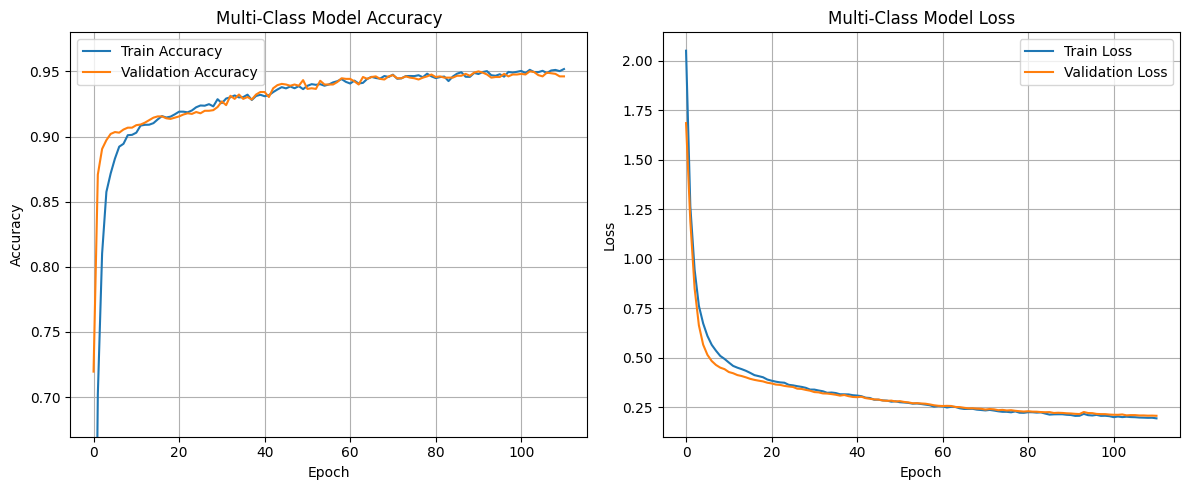


Generating Multi-Class confusion matrix & report...
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


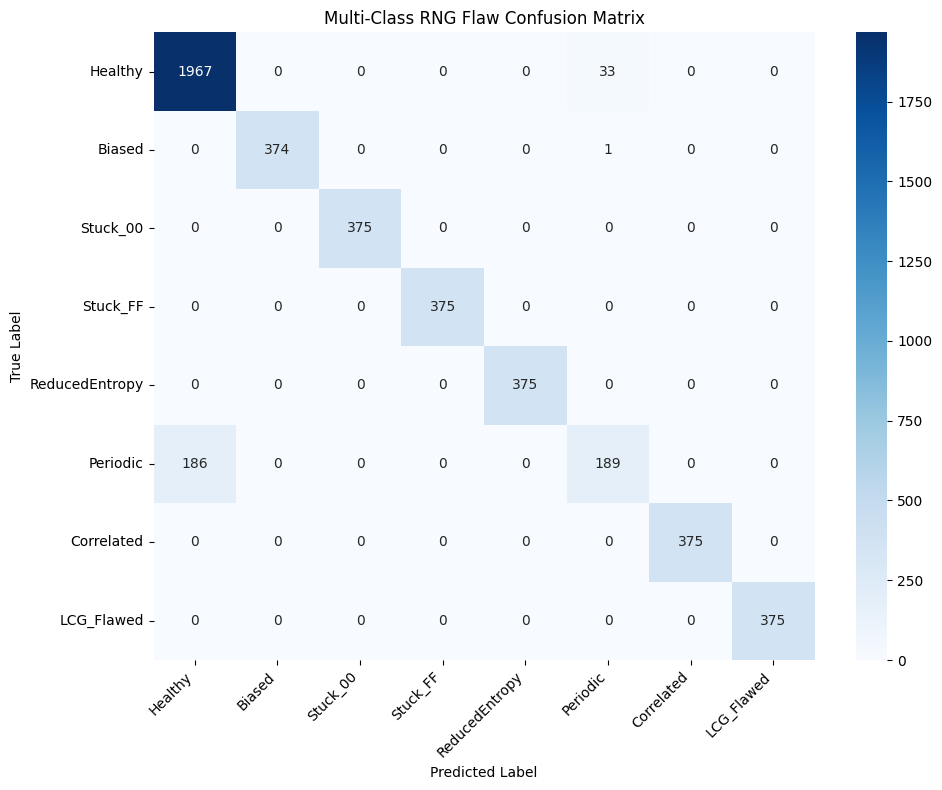


Multi-Class Classification Report:
                precision    recall  f1-score   support

       Healthy       0.91      0.98      0.95      2000
        Biased       1.00      1.00      1.00       375
      Stuck_00       1.00      1.00      1.00       375
      Stuck_FF       1.00      1.00      1.00       375
ReducedEntropy       1.00      1.00      1.00       375
      Periodic       0.85      0.50      0.63       375
    Correlated       1.00      1.00      1.00       375
    LCG_Flawed       1.00      1.00      1.00       375

      accuracy                           0.95      4625
     macro avg       0.97      0.94      0.95      4625
  weighted avg       0.95      0.95      0.95      4625

Multi-Class Evaluation complete.


In [ ]:
# Cell 10: Evaluate the Multi-Class Model
# This cell evaluates the performance of the trained multi-class RNG flaw detection model
# on the unseen test data. It calculates test accuracy and loss, plots the training
# history (accuracy and loss curves), and generates a confusion matrix and
# a detailed classification report.

print("\nEvaluating Multi-Class model on test data...")
# Evaluate the model on the test set to get loss and accuracy.
test_loss, test_acc = model_flaw_detector.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Multi-Class Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

print("Plotting Multi-Class training history...")
plt.figure(figsize=(12, 5)) # Set figure size for better readability.

# Plot training & validation accuracy values over epochs.
plt.subplot(1, 2, 1) # Create a subplot for accuracy.
plt.plot(history_flaw_detector.history['accuracy'], label='Train Accuracy')
plt.plot(history_flaw_detector.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multi-Class Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# Adjust y-axis limits for better visualization, ensuring the plot starts from a reasonable accuracy level.
plt.ylim(bottom=min(0.7, min(history_flaw_detector.history['val_accuracy'])-0.05) )
plt.legend()
plt.grid(True)

# Plot training & validation loss values over epochs.
plt.subplot(1, 2, 2) # Create a subplot for loss.
plt.plot(history_flaw_detector.history['loss'], label='Train Loss')
plt.plot(history_flaw_detector.history['val_loss'], label='Validation Loss')
plt.title('Multi-Class Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust subplot parameters for a tight layout.
plt.show() # Display the plots.

print("\nGenerating Multi-Class confusion matrix & report...")

# Get probability predictions for each class on the test set.
y_pred_proba_multi = model_flaw_detector.predict(X_test)
# Convert probabilities to predicted class labels by taking the argmax (index of the max probability).
y_pred_classes_multi = np.argmax(y_pred_proba_multi, axis=1)
y_true_classes_multi = y_test # True class labels for the test set.

# Compute the confusion matrix.
cm_multi = confusion_matrix(y_true_classes_multi, y_pred_classes_multi)
class_names = list(RNG_CLASSES.values()) # Get class names from the RNG_CLASSES dictionary.

# Plot the confusion matrix using seaborn's heatmap for better visualization.
plt.figure(figsize=(10, 8)) # Adjusted size for more classes
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Multi-Class RNG Flaw Confusion Matrix')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the classification report, which includes precision, recall, F1-score, and support for each class.
print("\nMulti-Class Classification Report:")
print(classification_report(y_true_classes_multi, y_pred_classes_multi, target_names=class_names))

print("Multi-Class Evaluation complete.")

In [ ]:
# Cell 11: Detailed Test Function (Multi-Class Version)
# This cell defines a function to perform a more granular test of the multi-class RNG flaw
# detection model. It generates a few new sequences for each defined RNG type (both healthy
# and various flaws) and evaluates the model's prediction against the known true label for each.
# It also provides a summary of how each true class was predicted.

def detailed_test_rng_flaws(model, scaler, seq_length=1024, num_tests_per_type=3):
    """
    Tests the multi-class RNG flaw detection model on newly generated sequences of various types.

    Args:
        model: The trained Keras model for multi-class flaw detection.
        scaler: The StandardScaler used to preprocess features for the model.
        seq_length (int): The length of the RNG sequences to generate.
        num_tests_per_type (int): The number of test sequences to generate for each RNG type.
    """
    print("\n" + "="*60)
    print("Detailed Test on Newly Generated Sequences (Multi-Class):")
    print("="*60)

    # Use the globally defined rng_generators and RNG_CLASSES
    test_generators = rng_generators # Dictionary mapping class_idx to generator function
    # true_labels dictionary is not explicitly needed here as class_idx is the true label.

    try:
        # Get expected feature length from the scaler.
        feature_len = scaler.n_features_in_
    except AttributeError:
         print("ERROR: Scaler does not seem to be fitted. Please ensure training (Cell 9) completed and scaler_multi is available.")
         return # Exit if scaler is not ready.

    # Initialize dictionaries to store results.
    results = {name: {'correct': 0, 'total': 0} for name in RNG_CLASSES.values()}
    overall_correct = 0
    overall_total = 0
    # For a more detailed breakdown of predictions (e.g., how 'Healthy' was classified)
    predictions_summary = {true_name: {pred_name: 0 for pred_name in RNG_CLASSES.values()}
                           for true_name in RNG_CLASSES.values()}

    # Iterate through each RNG type defined in test_generators.
    for class_idx, gen_func in test_generators.items():
        gen_name = RNG_CLASSES[class_idx] # Get the string name of the generator type.
        print(f"\n--- Testing Generator Type: {gen_name} (Class {class_idx}) ---")
        true_label = class_idx # The true class index.
        true_label_name = gen_name

        for i in range(num_tests_per_type):
            seq = gen_func() # Generate a new sequence.
            if len(seq) != seq_length: # Validate sequence length.
                 print(f" Length mismatch generating {gen_name}. Expected {seq_length}, got {len(seq)}. Skipping test {i+1}.")
                 continue

            features = extract_enhanced_features(seq) # Extract features.
            if len(features) != feature_len: # Validate feature length.
                 print(f" Feature length mismatch extracting from {gen_name}! Expected {feature_len}, got {len(features)}. Skipping test {i+1}.")
                 continue

            scaled_features = scaler.transform([features]) # Scale features.
            pred_proba_all = model.predict(scaled_features, verbose=0)[0] # Get prediction probabilities for all classes.
            pred_label = np.argmax(pred_proba_all) # Predicted class is the one with highest probability.
            pred_label_name = RNG_CLASSES[pred_label]
            is_correct = (true_label == pred_label)

            print(f" Test {i+1}: True='{true_label_name}' | Predicted='{pred_label_name}' (Confidence: {pred_proba_all[pred_label]:.3f}) {'[Correct]' if is_correct else '[INCORRECT]'}")

            # Update results and summary.
            results[gen_name]['total'] += 1
            overall_total += 1
            predictions_summary[true_label_name][pred_label_name] += 1
            if is_correct:
                results[gen_name]['correct'] += 1
                overall_correct += 1
        print("-" * 60)

    # Print summary of detailed test results.
    print("\n--- Detailed Multi-Class Test Summary ---")
    for gen_name, data in results.items():
        if data['total'] > 0:
            acc = (data['correct'] / data['total']) * 100
            print(f"  {gen_name:<20}: Accuracy = {acc:.2f}% ({data['correct']}/{data['total']})")
            # Print how this true class was predicted by the model.
            preds_for_this_true_class = predictions_summary[gen_name]
            pred_str_breakdown = ", ".join([f"{p_name}:{c}" for p_name, c in preds_for_this_true_class.items() if c > 0])
            print(f"     ↳ Predictions breakdown: {pred_str_breakdown}")

    overall_acc = (overall_correct / overall_total * 100) if overall_total > 0 else 0
    print(f"\nOverall Detailed Test Accuracy (Multi-Class): {overall_acc:.2f}% ({overall_correct}/{overall_total})")
    print("="*60)

print("Detailed test function defined.")

Detailed test function defined.


In [ ]:
# Cell 12: Run Detailed Test on Newly Generated Data for Multi-Class Model
# This cell executes the 'detailed_test_rng_flaws' function defined in the previous cell.
# It tests the trained multi-class model (model_flaw_detector) and its corresponding scaler (scaler_multi)
# on a small set of newly generated sequences for each RNG class.

# Optional: Load the saved model and scaler if needed (e.g., after restarting the Colab kernel).
# This is useful for deployments or if you don't want to retrain every time.
# try:
#     # Ensure the save paths match those used in Cell 9.
#     # model_load_path = os.path.join(save_directory, 'rng_flaw_detector_model.h5')
#     # scaler_load_path = os.path.join(save_directory, 'rng_flaw_scaler.pkl')
#     # model_flaw_detector = tf.keras.models.load_model(model_load_path)
#     # import joblib
#     # scaler_multi = joblib.load(scaler_load_path)
#     # print("Loaded saved model and scaler.")
# except Exception as e:
#     print(f"Could not load saved model/scaler: {e}. Ensure training (Cell 9) was run and files exist at specified paths.")

try:
    # Run the detailed test.
    # SEQ_LENGTH should be defined (from Cell 5).
    # num_tests_per_type=5 means 5 new sequences will be generated for each RNG class.
    detailed_test_rng_flaws(model_flaw_detector, scaler_multi, SEQ_LENGTH, num_tests_per_type=5)
except NameError as e:
    # Catch errors if model, scaler, or other necessary variables are not defined.
    print(f"Error: A required object (e.g., model_flaw_detector, scaler_multi, SEQ_LENGTH, RNG_CLASSES) is not defined: {e}.")
    print("Please ensure Cells 5, 7, 8, and 9 (for training/loading) have run successfully.")
except Exception as e:
    # Catch any other unexpected errors during the detailed testing.
    print(f"An unexpected error occurred during detailed testing: {e}")


Detailed Test on Newly Generated Sequences (Multi-Class):

--- Testing Generator Type: Healthy (Class 0) ---
 Test 1: True='Healthy' | Predicted='Healthy' (Confidence: 0.916) [Correct]
 Test 2: True='Healthy' | Predicted='Healthy' (Confidence: 0.956) [Correct]
 Test 3: True='Healthy' | Predicted='Healthy' (Confidence: 0.958) [Correct]
 Test 4: True='Healthy' | Predicted='Healthy' (Confidence: 0.950) [Correct]
 Test 5: True='Healthy' | Predicted='Healthy' (Confidence: 0.951) [Correct]
------------------------------------------------------------

--- Testing Generator Type: Biased (Class 1) ---
 Test 1: True='Biased' | Predicted='Biased' (Confidence: 1.000) [Correct]
 Test 2: True='Biased' | Predicted='Biased' (Confidence: 1.000) [Correct]
 Test 3: True='Biased' | Predicted='Biased' (Confidence: 1.000) [Correct]
 Test 4: True='Biased' | Predicted='Biased' (Confidence: 0.999) [Correct]
 Test 5: True='Biased' | Predicted='Biased' (Confidence: 1.000) [Correct]
-----------------------------

In [ ]:
# Cell 13: Q# Setup

%%qsharp
open Microsoft.Quantum.Intrinsic;
open Microsoft.Quantum.Measurement;

operation GenerateSingleRandomBitAsInt() : Int {
    use q = Qubit();
    H(q);
    let result = M(q);
    Reset(q);
    return result == One ? 1 | 0;
}

operation GenerateRandomByte() : Int {
    mutable byteValue = 0;
    for _ in 0..7 {
        let bit = GenerateSingleRandomBitAsInt();
        set byteValue = (byteValue <<< 1) ||| bit;
    }
    return byteValue;
}

In [ ]:
# Cell 14: Q# Byte Generation Function (Python Wrapper)
# This Python function acts as a wrapper to call the Q# `GenerateRandomByte` operation
# defined in the previous cell. It allows easy generation of a specified number of bytes
# from Python by repeatedly invoking the Q# simulator.

def generate_qsharp_bytes(num_bytes : int) -> bytes:
    """
    Generates a specified number of pseudo-random bytes using the simulated
    Q# QRNG operation 'GenerateRandomByte'.

    Args:
        num_bytes (int): The number of random bytes to generate.

    Returns:
        bytes: A bytes object containing the generated random bytes.
               Returns empty bytes if num_bytes is non-positive or if an error occurs.
    """
    if num_bytes <= 0:
        return b'' # Return empty bytes if a non-positive number of bytes is requested.

    print(f"Generating {num_bytes} bytes using simulated Q# QRNG...")
    start_time = time.time() # Record the start time for performance measurement.
    byte_list = [] # List to store the integer values of the generated bytes.
    try:
        # Loop to generate each byte individually by calling the Q# operation.
        for i in range(num_bytes):
            # `qsharp.run` executes the specified Q# operation.
            # `shots=1` indicates the operation should be run once for this call.
            # The result is a list (even for 1 shot), so we take the first element [0].
            byte_val = qsharp.run("GenerateRandomByte()", shots=1)[0]
            byte_list.append(byte_val)

        end_time = time.time() # Record the end time.
        print(f"Generation finished in {end_time - start_time:.2f} seconds.")
        return bytes(byte_list) # Convert the list of integer byte values to a Python `bytes` object.

    except Exception as e:
        # Handle potential errors during Q# execution (e.g., Q# not initialized, compilation errors).
        print(f"\nAn error occurred during Q# execution: {e}")
        print("Ensure Q# code cell (Cell 13) was executed successfully and qsharp is properly set up.")
        return b'' # Return empty bytes in case of an error.

In [ ]:
# Cell 15: Test QRNG Data with Multi-Class Model
# This cell evaluates the randomness quality of sequences generated by the simulated
# Q# Quantum Random Number Generator (QRNG). It uses the previously trained multi-class
# flaw detection model to classify these QRNG sequences.
# Ideally, a good QRNG should be classified as "Healthy".

print("\nTesting simulated QRNG output against the Multi-Class Flaw Detection model...")

try:
    # Check if necessary model and scaler objects are defined and compatible.
    if not 'model_flaw_detector' in locals() or not 'scaler_multi' in locals():
         raise NameError("Model (model_flaw_detector) or Scaler (scaler_multi) not defined. Run previous training/loading cells.")
    if not 'EXPECTED_FEATURE_LENGTH' in locals():
         raise NameError("EXPECTED_FEATURE_LENGTH not defined. Run feature extraction cell (Cell 4).")
    if not 'RNG_CLASSES' in locals():
         raise NameError("RNG_CLASSES dictionary not defined. Run setup cell (Cell 5).")

    print(f"Model input shape expected: {model_flaw_detector.input_shape}")
    print(f"Scaler expects {scaler_multi.n_features_in_} features.")
    # Validate feature length consistency.
    if scaler_multi.n_features_in_ != EXPECTED_FEATURE_LENGTH:
         raise ValueError(f"Scaler expects {scaler_multi.n_features_in_} features, but feature function (extract_enhanced_features) generates {EXPECTED_FEATURE_LENGTH}")

except Exception as e:
     print(f"\nERROR checking model/scaler setup: {e}")
     raise # Stop execution if setup is incorrect.

num_qrng_tests = 5       # Number of QRNG sequences to generate and test.
seq_length_qrng = 1024   # Length of each QRNG sequence in bytes (must match model training).

# Check if qsharp was successfully imported/initialized.
if 'qsharp' not in globals() or not qsharp:
     print("\nQsharp not available. Skipping QRNG tests.")
else:
    for i in range(num_qrng_tests):
        print(f"\n--- QRNG Test Sample {i+1} ---")
        print(f" Generating {seq_length_qrng} bytes using Q# simulator (this may take time)...")
        qrng_sequence = generate_qsharp_bytes(seq_length_qrng) # Generate QRNG sequence.

        # Validate the generated sequence.
        if not qrng_sequence or len(qrng_sequence) != seq_length_qrng:
            print(" Failed to generate valid QRNG sequence. Skipping test.")
            continue

        print(" Extracting features...")
        qrng_features = extract_enhanced_features(qrng_sequence) # Extract features.

        # Further validation of feature length before scaling and prediction.
        if len(qrng_features) != EXPECTED_FEATURE_LENGTH:
             print(f" Error: Feature length mismatch after extraction! Got {len(qrng_features)}, expected {EXPECTED_FEATURE_LENGTH}. Skipping test.")
             continue
        if len(qrng_features) != scaler_multi.n_features_in_: # Should be redundant if above passes, but good check.
             print(f" Error: Feature length {len(qrng_features)} does not match scaler expected input {scaler_multi.n_features_in_}. Skipping test.")
             continue

        print(" Scaling features...")
        # Scale the extracted features using the pre-fitted scaler.
        scaled_qrng_features = scaler_multi.transform(qrng_features.reshape(1, -1)) # Reshape for single sample.

        print(" Predicting flaw type...")
        # Predict the class probabilities using the multi-class model.
        pred_proba_qrng_all_classes = model_flaw_detector.predict(scaled_qrng_features, verbose=0)[0]
        pred_label_idx = np.argmax(pred_proba_qrng_all_classes) # Get the class with the highest probability.
        pred_label_name = RNG_CLASSES[pred_label_idx] # Get the string name of the predicted class.
        pred_confidence = pred_proba_qrng_all_classes[pred_label_idx] # Confidence of the prediction.

        # Print prediction results.
        print(f" > Predicted Class: '{pred_label_name}' (Confidence: {pred_confidence:.4f})")
        print(f" > EXPECTED Class for ideal QRNG: '{RNG_CLASSES[0]}' (Healthy)")
        # Provide a warning if the QRNG sequence is not classified as "Healthy".
        if pred_label_idx != 0:
            print(f"   WARNING: Model predicted the QRNG sequence might be flawed (predicted as '{pred_label_name}').")
        else:
            print("   Model prediction aligns with expectation for a good RNG.")

    print("\nQRNG testing complete.")


Testing simulated QRNG output against the Multi-Class Flaw Detection model...
Model input shape expected: (None, 131)
Scaler expects 131 features.

--- QRNG Test Sample 1 ---
 Generating 1024 bytes using Q# simulator (this may take time)...
Generating 1024 bytes using simulated Q# QRNG...
Generation finished in 0.37 seconds.
 Extracting features...
 Scaling features...
 Predicting flaw type...
 > Predicted Class: 'Healthy' (Confidence: 0.8211)
 > EXPECTED Class for ideal QRNG: 'Healthy' (Healthy)
   Model prediction aligns with expectation for a good RNG.

--- QRNG Test Sample 2 ---
 Generating 1024 bytes using Q# simulator (this may take time)...
Generating 1024 bytes using simulated Q# QRNG...
Generation finished in 1.04 seconds.
 Extracting features...
 Scaling features...
 Predicting flaw type...
 > Predicted Class: 'Healthy' (Confidence: 0.9358)
 > EXPECTED Class for ideal QRNG: 'Healthy' (Healthy)
   Model prediction aligns with expectation for a good RNG.

--- QRNG Test Sample 

In [ ]:
# Cell 16: Test APUF/CSV Data with Multi-Class Model (Requires Drive Mount)
# This cell is designed to load data from a CSV file (presumably containing APUF responses),
# process this data into byte sequences, and then use the trained multi-class RNG flaw
# detection model to classify these sequences.

import pandas as pd # For reading CSV files.
# Ensure other necessary imports like os, re, np, time are available (imported in Cell 2).

try:
    drive.mount('/content/drive', force_remount=True) # Mount Google Drive.
    drive_mounted = True
except Exception as e:
    print(f"Could not mount Google Drive: {e}. Skipping CSV test.")
    drive_mounted = False

if drive_mounted:
    print("\nAttempting to test model on data from CSV file (APUF sequences)...")
    # Path to the CSV file in Google Drive.
    csv_file_path = '/content/drive/MyDrive/binary_20Stages_32Bits_APUF_5 - binary_20Stages_32Bits_APUF_5.csv'

    if not os.path.exists(csv_file_path):
        print(f"\nERROR: CSV file not found at: {csv_file_path}")
    else:
        print(f"Reading 32-bit sequences from first column of: {csv_file_path}")
        binary_strings_32bit_apuf = []
        try:
            # Read only the first column, no header, treat as string.
            df_apuf = pd.read_csv(csv_file_path, usecols=[0], header=None, dtype=str, low_memory=False)
            raw_column_apuf = df_apuf[0].tolist() # Convert to list.

            # Validate each item to ensure it's a 32-bit binary string.
            pattern_apuf = re.compile(r"^[01]{32}$")
            count_invalid_apuf = 0
            for item in raw_column_apuf:
                if isinstance(item, str) and pattern_apuf.match(item.strip()):
                     binary_strings_32bit_apuf.append(item.strip())
                else:
                    count_invalid_apuf += 1
            if count_invalid_apuf > 0:
                 print(f" Warning: Skipped {count_invalid_apuf} invalid entries in the CSV first column (not 32-bit binary).")

        except Exception as e:
             print(f"\nAn error occurred while reading the CSV file: {e}")
             binary_strings_32bit_apuf = [] # Ensure list is empty on error.

        print(f" Found and validated {len(binary_strings_32bit_apuf)} potential 32-bit binary sequences from CSV.")

        # Construct 1024-byte sequences (1024 bytes = 256 * 32-bit numbers, as 32 bits = 4 bytes).
        nums_per_sequence_apuf = 256
        sequences_to_test_apuf = []
        # Iterate to form 1024-byte sequences by concatenating 256 of the 32-bit numbers.
        for i in range(0, len(binary_strings_32bit_apuf) - nums_per_sequence_apuf + 1, nums_per_sequence_apuf):
            sequence_bytes_list_apuf = []
            valid_segment_apuf = True
            for j in range(nums_per_sequence_apuf):
                bin_str_apuf = binary_strings_32bit_apuf[i+j]
                try:
                    int_val_apuf = int(bin_str_apuf, 2) # Convert binary string to integer.
                    four_bytes_apuf = int_val_apuf.to_bytes(4, byteorder='big', signed=False) # Convert int to 4 bytes.
                    sequence_bytes_list_apuf.append(four_bytes_apuf)
                except ValueError:
                    print(f"Error converting binary string from CSV: {bin_str_apuf} at source index {i+j}")
                    valid_segment_apuf = False
                    break
            if valid_segment_apuf:
                sequences_to_test_apuf.append(b"".join(sequence_bytes_list_apuf)) # Join bytes.

        num_sequences_found_apuf = len(sequences_to_test_apuf)
        print(f" Constructed {num_sequences_found_apuf} sequences of 1024 bytes from CSV.")

        max_tests_apuf = 5 # Limit number of sequences to test from CSV for brevity.
        sequences_tested_count_apuf = 0

        if num_sequences_found_apuf == 0:
            print("\nCould not construct any full 1024-byte sequences from the CSV data.")
        else:
            print(f"\nTesting the first {min(max_tests_apuf, num_sequences_found_apuf)} sequence(s) found in the CSV with Multi-Class Model...")

            try:
                # Check for model and scaler existence and compatibility.
                if not 'model_flaw_detector' in locals() or not 'scaler_multi' in locals():
                     raise NameError("Model or Scaler not defined. Run previous training/loading cells.")
                print(f" Model expects input shape: {model_flaw_detector.input_shape}")
                print(f" Scaler expects {scaler_multi.n_features_in_} features.")
                if scaler_multi.n_features_in_ != EXPECTED_FEATURE_LENGTH:
                     raise ValueError(f"Scaler expects {scaler_multi.n_features_in_} features, but function generates {EXPECTED_FEATURE_LENGTH}")
                print("-" * 30)
            except Exception as e:
                 print(f"\nERROR checking model/scaler: {e}"); raise # Stop if setup issues.

            # Test a subset of the constructed APUF sequences.
            for k, apuf_sequence in enumerate(sequences_to_test_apuf):
                if k >= max_tests_apuf: break # Test only 'max_tests_apuf' sequences.
                sequences_tested_count_apuf += 1
                print(f"\n--- APUF/CSV Sequence Test {k+1} ---")

                if len(apuf_sequence) != 1024: # Should be 1024 due to construction logic.
                     print(f" Error: Constructed sequence length is {len(apuf_sequence)}, expected 1024. Skipping.")
                     continue

                try:
                    print(" Extracting features...")
                    apuf_features = extract_enhanced_features(apuf_sequence)
                    if len(apuf_features) != EXPECTED_FEATURE_LENGTH:
                         print(f" Error: Feature length mismatch! Got {len(apuf_features)}, expected {EXPECTED_FEATURE_LENGTH}")
                         continue

                    print(" Scaling features...")
                    scaled_apuf_features = scaler_multi.transform(apuf_features.reshape(1, -1))

                    print(" Predicting flaw type...")
                    pred_proba_apuf = model_flaw_detector.predict(scaled_apuf_features, verbose=0)[0]
                    pred_label_idx_apuf = np.argmax(pred_proba_apuf)
                    pred_label_name_apuf = RNG_CLASSES[pred_label_idx_apuf]
                    pred_confidence_apuf = pred_proba_apuf[pred_label_idx_apuf]

                    print(f" > Predicted Class for APUF/CSV Sequence {k+1}: '{pred_label_name_apuf}' (Confidence: {pred_confidence_apuf:.4f})")
                    print("   (The model assesses this sequence based on patterns learned from simulated flaws and healthy TRNG data)")

                except Exception as e:
                    print(f" An error occurred during processing APUF/CSV sequence {k+1}: {e}")
                    import traceback
                    traceback.print_exc() # Print full traceback for debugging.

            print(f"\nAPUF/CSV data testing complete (tested {sequences_tested_count_apuf} sequences).")
else:
    print("\nGoogle Drive not mounted. Skipping APUF/CSV data test.")

Mounted at /content/drive

Attempting to test model on data from CSV file (APUF sequences)...
Reading 32-bit sequences from first column of: /content/drive/MyDrive/binary_20Stages_32Bits_APUF_5 - binary_20Stages_32Bits_APUF_5.csv
 Found and validated 9996 potential 32-bit binary sequences from CSV.
 Constructed 39 sequences of 1024 bytes from CSV.

Testing the first 5 sequence(s) found in the CSV with Multi-Class Model...
 Model expects input shape: (None, 131)
 Scaler expects 131 features.
------------------------------

--- APUF/CSV Sequence Test 1 ---
 Extracting features...
 Scaling features...
 Predicting flaw type...
 > Predicted Class for APUF/CSV Sequence 1: 'Biased' (Confidence: 0.9584)
   (The model assesses this sequence based on patterns learned from simulated flaws and healthy TRNG data)

--- APUF/CSV Sequence Test 2 ---
 Extracting features...
 Scaling features...
 Predicting flaw type...
 > Predicted Class for APUF/CSV Sequence 2: 'Biased' (Confidence: 1.0000)
   (The mo

In [ ]:
# Cell 17: Sequence Generation and Saving to Drive (Commented Out)
# This cell contains commented-out code that was likely intended for generating
# specific types of RNG sequences and saving them to Google Drive.
# It demonstrates how one might programmatically create and store datasets.
# To use it, uncomment the code and ensure Google Drive is mounted (as in Cell 9 or 16).

# if not drive_mounted: # Check if Drive is mounted; attempt to mount if not.
#     try:
#         drive.mount('/content/drive', force_remount=True)
#         drive_mounted = True
#         print("Google Drive mounted.")
#     except Exception as e:
#         print(f"Could not mount Google Drive: {e}. Cannot save sequences.")
#         drive_mounted = False


# def generate_and_save_sequence(rng_type_name, seq_len, save_dir="/content/drive/MyDrive/generated_rng_data"):
#     """Generates a sequence using the specified RNG type and saves it to a file in Google Drive."""
#     if not drive_mounted: # Requires Drive to be mounted.
#         print("Error: Google Drive not mounted. Cannot save file.")
#         return

#     generator_func = None
#     class_idx = -1
#     # Find the generator function based on the provided rng_type_name.
#     for idx, name in RNG_CLASSES.items():
#         if name.lower() == rng_type_name.lower():
#             generator_func = rng_generators.get(idx)
#             class_idx = idx
#             break

#     if generator_func is None: # Handle case where RNG type is not found.
#         print(f"Error: RNG type '{rng_type_name}' not found in defined generators.")
#         print(f"Available types: {list(RNG_CLASSES.values())}")
#         return

#     print(f"Generating sequence of length {seq_len} using '{rng_type_name}' generator...")
#     try:
#         # This block has redundant direct calls to generator functions.
#         # The `generator_func()` from the dictionary lookup should suffice if `rng_generators` is comprehensive.
#         # The original logic seemed to try a direct call if the lambda-wrapped one failed or had issues.
#         # For simplicity, a direct call to `generator_func()` (which uses the lambda) is preferred.
#         # The code below tries to replicate the original intent which might have been for debugging or specific cases.

        # sequence_bytes = b'' # Initialize
#         if rng_type_name.lower() == "healthy":
#             sequence_bytes = generate_healthy_trng(seq_len)
#         elif rng_type_name.lower() == "biased":
#              sequence_bytes = generate_biased_trng(seq_len) # Default bias will be used from function def.
#         elif rng_type_name.lower() == "stuck_00":
#              sequence_bytes = generate_stuck_trng(seq_len, stuck_value=0x00) # Default prob/run_length
#         elif rng_type_name.lower() == "stuck_ff":
#              sequence_bytes = generate_stuck_trng(seq_len, stuck_value=0xFF) # Default prob/run_length
#         elif rng_type_name.lower() == "reducedentropy": # Corrected typo from ReducedEntropy
#              sequence_bytes = generate_reduced_entropy_trng(seq_len) # Default min/max
#         elif rng_type_name.lower() == "periodic":
#              sequence_bytes = generate_periodic_trng(seq_len) # Default period/amplitude
#         elif rng_type_name.lower() == "correlated":
#              sequence_bytes = generate_correlated_trng(seq_len) # Default alpha
#         elif rng_type_name.lower() == "lcg_flawed":
#              sequence_bytes = generate_lcg_bytes(seq_len) # Default seed
#         else: # Fallback to the dictionary generator if specific if/else not matched
#             sequence_bytes = generator_func() # This should generate SEQ_LENGTH (1024) by default
             # If a different length is needed, the lambda in rng_generators would need to accept seq_len
             # or this logic needs refinement. Current lambdas use global SEQ_LENGTH.
             # The following lines attempt to re-generate if length is wrong, which is complex.

#              if len(sequence_bytes) != seq_len: # Check if lambda produced correct length
#                   print(f"Warning: Lambda generator for {rng_type_name} produced length {len(sequence_bytes)}, requested {seq_len}. Trying direct call with specific length.")
                    # This part is tricky because generate_..._trng functions take length as first arg
                    # but the lambdas in rng_generators might have hardcoded or global SEQ_LENGTH.
                    # A cleaner way would be to make lambdas accept length or have separate functions for variable lengths.
#                   base_func_name = f"generate_{rng_type_name.lower()}_trng" \
#                                    if "stuck" not in rng_type_name.lower() and \
#                                       "lcg" not in rng_type_name.lower() and \
#                                       "reducedentropy" not in rng_type_name.lower() \
#                                    else (f"generate_{rng_type_name.lower()}" if "lcg" in rng_type_name.lower() else f"generate_{rng_type_name.lower()}_trng")
                    # This dynamic naming is fragile. Explicit calls are better.
                    # Example: if rng_type_name == "Healthy": sequence_bytes = generate_healthy_trng(seq_len)
#                   if base_func_name in globals(): # Check if the dynamically constructed function name exists
#                        sequence_bytes = globals()[base_func_name](seq_len) # Call it with the desired seq_len
#                   else:
#                        print(f"Could not find base function for {rng_type_name}. Cannot generate variable length. Using lambda output.")
                        # If it still fails, it will use the potentially wrong length output from lambda.

#         # Final check on sequence length before saving.
#         if len(sequence_bytes) != seq_len:
#             print(f"Error: Final generated sequence length is {len(sequence_bytes)}, expected {seq_len}. Aborting save.")
#             return

#     except Exception as e:
#         print(f"Error generating sequence for '{rng_type_name}': {e}")
#         return

#     # Create the save directory if it doesn't exist.
#     try:
#         os.makedirs(save_dir, exist_ok=True)
#     except Exception as e:
#         print(f"Error creating directory {save_dir}: {e}")
#         return

#     # Create a filename with RNG type, length, and timestamp.
#     timestamp = time.strftime("%Y%m%d_%H%M%S")
#     filename = f"{rng_type_name.lower()}_len{seq_len}_{timestamp}.bin" # .bin extension for binary data.
#     filepath = os.path.join(save_dir, filename)

#     print(f"Saving sequence to: {filepath}")
#     try:
#         with open(filepath, 'wb') as f: # Open file in write binary ('wb') mode.
#             f.write(sequence_bytes)
#         print("Sequence saved successfully.")
#     except Exception as e:
#         print(f"Error saving sequence to file: {e}")


# # Example usage (if drive_mounted is True and functions are correctly defined/accessible):
# if drive_mounted:
#     # To make these work correctly, ensure the generate_* functions or their lambdas handle `seq_len`
#     # if it's different from the global SEQ_LENGTH used in training data generation.
#     # The current generate_and_save_sequence has complex logic for this; simpler might be to
#     # define specific lambdas in rng_generators that take length.
#     # For now, this will likely try to use the functions which are designed for the global SEQ_LENGTH (1024).
#     # If you call generate_and_save_sequence("Healthy", 2048), the lambda for "Healthy" will still
#     # generate 1024 bytes because `generate_healthy_trng(SEQ_LENGTH)` is called by the lambda.
#     # The internal logic of generate_and_save_sequence attempts to fix this but is a bit convoluted.

#     # Example 1: Generate a 2048-byte Healthy sequence
#     # generate_and_save_sequence("Healthy", 2048) # This will likely produce 1024 bytes due to lambda

#     # Example 2: Generate a 1024-byte LCG_Flawed sequence
#     # generate_and_save_sequence("LCG_Flawed", 1024)

#     # Example 3: Generate a 512-byte Periodic sequence and save to a different directory
#     # generate_and_save_sequence("Periodic", 512, save_dir="/content/drive/MyDrive/other_rng_data")
#     pass # Pass to avoid execution of commented code
# else:
#      print("\nSkipping sequence generation and saving examples as Google Drive is not mounted.")